# 02_Prototipo Fuzzy básico

Este notebook se implementa paso a paso un sistema neuro-difuso (ANFIS) para la clasificación de la calidad del agua. Incluye:

1. Preprocesamiento (winsorization ya aplicado, normalización)
2. División en entrenamiento y validación
3. Definición y construcción del modelo FUZZY usando nuestro módulo `src/neurofuzzy`
4. Entrenamiento y monitoreo de la pérdida
5. Evaluación del modelo y guardado del resultado


## 1. Importar librerías

In [1]:
import pandas as pd
import numpy as np
import os, sys
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

%matplotlib inline

import skfuzzy as fuzz

## 2. Cargar datos winsorizados y preparar características

In [2]:
# Ajusta la ruta si es necesario
df_wins = pd.read_csv('../data/processed/winsorized_water_quality.csv', sep=";")

# Definir variables de entrada y etiqueta
feature_cols = [c for c in df_wins.columns if c != 'Water Quality']
X = df_wins[feature_cols].values
y = df_wins['Water Quality'].values

print(f"Formas: X={X.shape}, y={y.shape}")

Formas: X=(4300, 13), y=(4300,)


## 3. Normalización Min–Max y división Train/Test

In [3]:
# Normalización a [0,1]
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

# Guardar scaler para producción
import pickle
os.makedirs('models', exist_ok=True)
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# División 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (3440, 13), Val: (860, 13)


In [ ]:
# El notebook debe estás en <root>/notebooks/
# sube un nivel para que Python encuentre la carpeta src/

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Raiz del prooyecto añadida a sys.path:", project_root)


Raiz del prooyecto añadida a sys.path: c:\fuzzy_calidad_agua


## 5. Evaluación del Sistema Difuso básico

In [5]:
# 6. Evaluación del sistema difuso
from src.neurofuzzy.model import create_fuzzy_control_system
from src.neurofuzzy.predict import infer_fuzzy

# 6.1 Crear el simulador usando df_wins y feature_cols
sim = create_fuzzy_control_system(df_wins, feature_cols)

# 6.2 Inferir training set
y_pred_train = [infer_fuzzy(sim, x, feature_cols) for x in X_train]
# 6.3 Inferir validation set
y_pred_val   = [infer_fuzzy(sim, x, feature_cols) for x in X_val]

# 6.4 Redondear al entero más cercano para obtener la clase
y_pred_train_cls = np.rint(y_pred_train).astype(int)
y_pred_val_cls   = np.rint(y_pred_val).astype(int)

# 6.5 Cálculo de métricas
print("▶︎ Train Accuracy:", accuracy_score(y_train, y_pred_train_cls))
print("▶︎ Val   Accuracy:", accuracy_score(y_val,   y_pred_val_cls))

print("\n▶︎ Val Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_cls))

print("\n▶︎ Val Classification Report:")
print(classification_report(y_val, y_pred_val_cls, target_names=['Poor','Good','Excellent']))


▶︎ Train Accuracy: 0.32558139534883723
▶︎ Val   Accuracy: 0.32558139534883723

▶︎ Val Confusion Matrix:
[[  0 280   0]
 [  0 280   0]
 [  0 300   0]]

▶︎ Val Classification Report:
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00       280
        Good       0.33      1.00      0.49       280
   Excellent       0.00      0.00      0.00       300

    accuracy                           0.33       860
   macro avg       0.11      0.33      0.16       860
weighted avg       0.11      0.33      0.16       860



c:\fuzzy_calidad_agua\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\fuzzy_calidad_agua\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\fuzzy_calidad_agua\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 6. Análisis Gráfico del Sistema Difuso básico

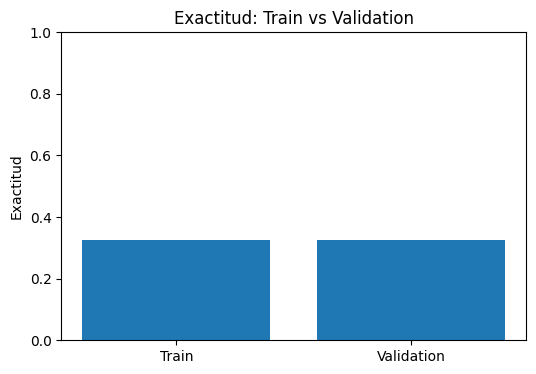

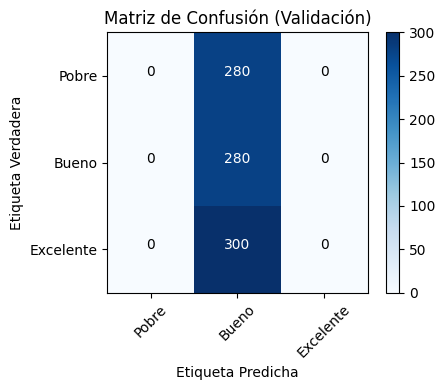

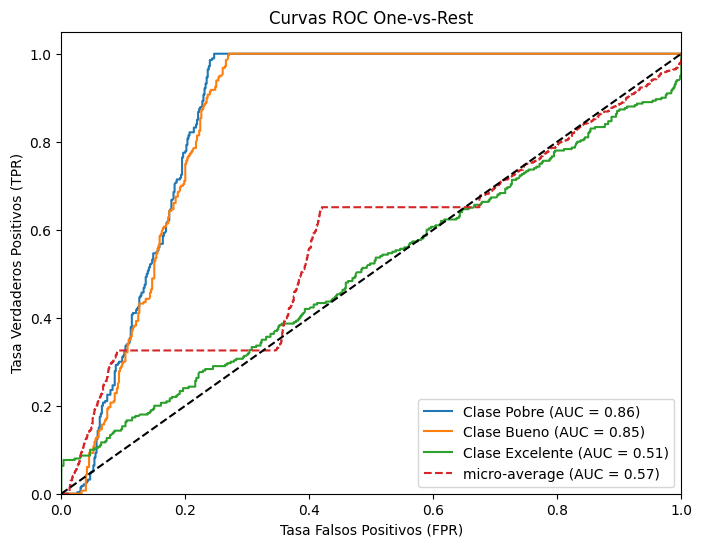

In [6]:
# 1. Gráfico de barras de Accuracy
acc_train = accuracy_score(y_train, y_pred_train_cls)
acc_val   = accuracy_score(y_val,   y_pred_val_cls)

plt.figure(figsize=(6,4))
plt.bar(['Train', 'Validation'], [acc_train, acc_val])
plt.ylim(0, 1)
plt.ylabel('Exactitud')
plt.title('Exactitud: Train vs Validation')
plt.show()

# 2. Mapa de calor de la matriz de confusión (Validation)
cm = confusion_matrix(y_val, y_pred_val_cls)
labels = ['Pobre', 'Bueno', 'Excelente']

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de Confusión (Validación)')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
# Anotar valores
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# 3. Curvas ROC y AUC (One-vs-Rest usando defecto continuo)
# Binarizar etiquetas
y_val_bin = label_binarize(y_val, classes=[0,1,2])
# Definir puntuaciones a partir del valor difuso continuous entre 0-2
y_score = np.vstack([1 - np.abs(np.array(y_pred_val) - i)/2 for i in [0,1,2]]).T

# Calcular fpr, tpr y AUC
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8,6))
for i, color in zip(range(3), ['blue', 'green', 'red']):
    plt.plot(fpr[i], tpr[i],
             label=f'Clase {labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle='--')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Tasa Falsos Positivos (FPR)')
plt.ylabel('Tasa Verdaderos Positivos (TPR)')
plt.title('Curvas ROC One-vs-Rest')
plt.legend(loc='lower right')
plt.show()

### 7. Gráfica de curva Fuzzy del sistema

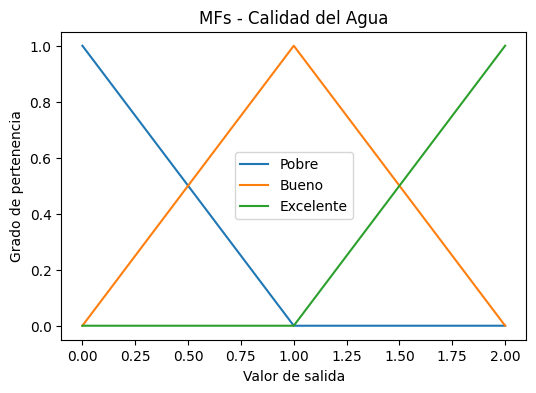

In [7]:
from src.reglas.rules_builder import build_consequent

consequent = build_consequent()
y      = consequent.universe
poor   = consequent['Pobre'].mf
good   = consequent['Bueno'].mf
excel  = consequent['Excelente'].mf

plt.figure(figsize=(6,4))
plt.plot(y, poor,  label='Pobre')
plt.plot(y, good,  label='Bueno')
plt.plot(y, excel, label='Excelente')
plt.title('MFs - Calidad del Agua')
plt.xlabel('Valor de salida'); plt.ylabel('Grado de pertenencia')
plt.legend(); plt.show()


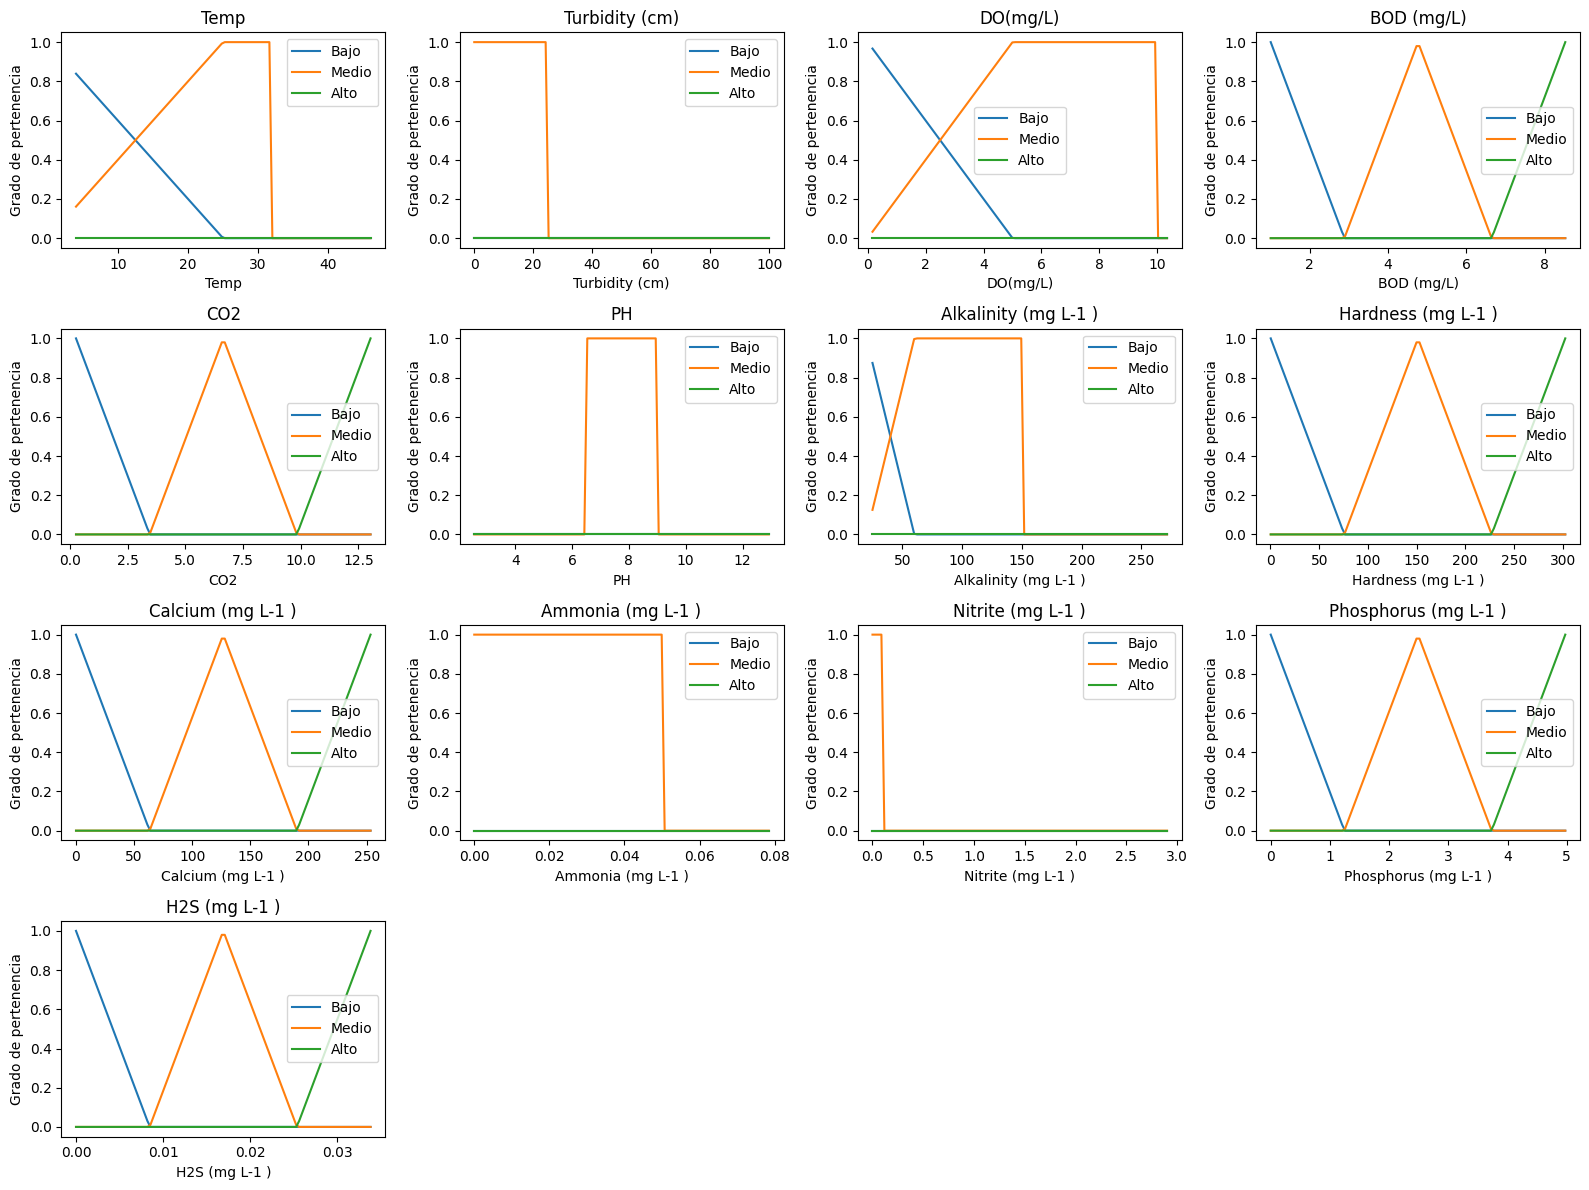

In [8]:
from src.pertenencia.membership_functions import generate_universes, create_mfs

# 1. Generar universos y MFs
universes = generate_universes(df_wins, feature_cols)
mfs       = create_mfs(universes)

# 2. Configurar subplots en 4 columnas
n_vars = len(feature_cols)
ncols  = 4
nrows  = math.ceil(n_vars / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = axes.flatten()

# 3. Graficar MFs de cada variable
for idx, var in enumerate(feature_cols):
    ax = axes[idx]
    x  = universes[var]
    f  = mfs[var]
    ax.plot(x, f['low'],    label='Bajo')
    ax.plot(x, f['medium'], label='Medio')
    ax.plot(x, f['high'],   label='Alto')
    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('Grado de pertenencia')
    ax.legend()

# 4. Eliminar ejes vacíos
for ax in axes[n_vars:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


En los plots vemos que, tal como los definimos con los umbrales normativos “crudos”, algunas funciones de pertenencia han quedado degeneradas (esencialmente 0 ó 1 todo el rango) o con solapamientos muy estrechos. Esto se aprecia sobre todo en:

- Turbidity (cm) y Ammonia (mg L⁻¹), donde los umbrales bajo–medio–alto confluyen en el mismo par de valores y generan trapecios/picos planos.

- Nitrite (mg L⁻¹), cuyo rango bajo es prácticamente todo el universo y el alto nunca llega a activarse salvo justo en el extremo.

- Variables con rangos muy amplios (Alkalinity, Hardness, Calcium), donde la “campana” media ocupa casi todo el eje y las colas bajas y altas apenas se notan.

### ¿Qué podemos hacer?
1. Revisar los umbrales normativos
Para que las MFs sean informativas, conviene definir:

- Low: [min_data, min_data, thresh_low]
- Medium: [thresh_low, (thresh_low+thresh_high)/2, thresh_high]
- High: [thresh_high, max_data, max_data]

De este modo recuperamos un poco de solapamiento y evitamos degeneraciones.

2. Ajustar manualmente los rangos para “bajo” y “alto”
Para las variables con umbrales idénticos (por ejemplo Ammonia: 0.0–0.05–0.05–0.05), podríamos:

- Poner low = 0.0, medium = [0.0, 0.025, 0.05], high = [0.05, 0.08, max_data]
- O usar el rango de datos reales para delimitar “alto”.

3. Volver a generar y graficar
Con estos ajustes tendrás MFs suaves, con picos “en triángulo” bien formados y solapamientos controlados, esenciales para que el ANFIS aprenda correctamente.